In [2]:
import cirq
import random
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def make_qft_inverse(q):
    for x in range(len(q)):
        yield cirq.H(q[x])
        #add cz power gates connecting this qubit to each of lower ones
        for y in range(len(q) - x - 1):
            exp = -1 * .5 ** (y + 1) #the gate powers are exponents of 1/2 (negative for inv)
            yield cirq.CZ(q[y + x + 1],q[x]) ** exp

In [7]:
#Quantum Phase Estimation algorithm
"""Set up the unitary and number of bits to use in phase estimation."""
# Value of θ which appears in the definition of the unitary U above.
# Try different values.
theta = 1

# Define the unitary U. It's arbitrary
U = cirq.Z ** (2 * theta)

# Accuracy of the estimate for theta. Try different values.
n_bits = 3

In [8]:
c = cirq.Circuit()

qbit = cirq.LineQubit.range(n_bits)
opt = cirq.NamedQubit('U')

c.append(cirq.X(opt))#state doesnt really matter here

for q in qbit:
    c.append(cirq.H(q))

for x in range(len(qbit)):
    power = 2 ** (len(qbit) - x - 1)# 2^(n-1), 2^n-2, 2^n-3 ...    
    c.append(cirq.ControlledGate(U).on(qbit[x], opt) ** power)#Controlled U to the power

c.append(make_qft_inverse(qbit))
c.append(cirq.measure(*qbit, key='m'))

print(c)

                               ┌────────┐
0: ───H───@─────H─────@─────────@────────────────────────M('m')───
          │           │         │                        │
1: ───H───┼─────@─────@^-0.5────┼──────H────@────────────M────────
          │     │               │           │            │
2: ───H───┼─────┼─────@─────────@^-0.25─────@^-0.5───H───M────────
          │     │     │
U: ───X───Z^0───Z^0───Z^0─────────────────────────────────────────
                               └────────┘


In [10]:
#Simulate
sim = cirq.Simulator()
result = sim.run(c, repetitions=10)

# Convert from output bitstrings to estimate θ values.
theta_estimates = np.sum(2 ** np.arange(n_bits) * result.measurements['m'], axis=1) / 2**n_bits
print(theta_estimates)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
def phase_estimation(theta, n_bits, n_reps=10, u_prep_gate=cirq.X):
    circuit = cirq.Circuit()
    qbit = cirq.LineQubit.range(n_bits)
    ubit = cirq.NamedQubit("U")
    U = cirq.Z ** (2 * theta)#gate
    
    #Prepare state psi
    circuit.append(u_prep_gate(ubit))
    
    #Apply Hadamards
    for q in qbit:
        circuit.append(cirq.H(q))
    
    #Apply controlled U operations
    for x in range(n_bits):
        power = 2 ** (n_bits - x - 1) # 2^(n-1), 2^n-2, 2^n-3 ...
        circuit.append(cirq.ControlledGate(U).on(qbit[x], ubit) ** power)
        
    #Inverse QFT
    circuit.append(make_qft_inverse(qbit))
    
    #Measure
    circuit.append(cirq.measure(*qbit, key='m'))
    
    #Simulate
    sim = cirq.Simulator()
    result = sim.run(circuit, repetitions=n_reps)
    theta_estimate = np.sum(2 ** np.arange(n_bits) * result.measurements['m'], axis=1) / 2**n_bits
    
    return theta_estimate

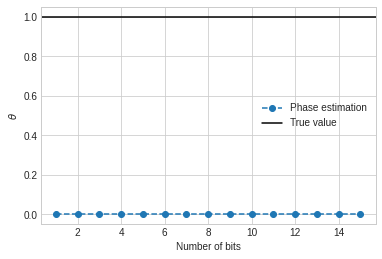

In [14]:
#FROM TUTORIAL
"""Analyze convergence vs n_bits."""
# Set the value of theta. Try different values.
theta = 1

max_nvals = 16
nvals = np.arange(1, max_nvals, step=1)

# Get the estimates at each value of n.
estimates = []
for n in nvals:
    estimate = phase_estimation(theta=theta, n_bits=n, n_reps=1)[0]
    estimates.append(estimate)

"""Plot the results."""
plt.style.use("seaborn-whitegrid")

plt.plot(nvals, estimates, "--o", label="Phase estimation")
plt.axhline(theta, label="True value", color="black")

plt.legend()
plt.xlabel("Number of bits")
plt.ylabel(r"$\theta$");

In [20]:
#What if we don't know psi?
"""Run phase estimation without starting in an eigenstate."""
# Value of theta.
theta = .4567

# Number of qubits.
n = 4

# Run phase estimation starting in the state H|0⟩ = |+⟩.
res = phase_estimation(theta=theta, n_bits=n, n_reps=10, u_prep_gate=cirq.H)
print(res)

#Only correct 1/2 the time! Shors algorithm is basically this algorithm and has the same constraint

[0.4375 0.     0.4375 0.4375 0.     0.     0.     0.     0.375  0.5   ]
